In [5]:
import time
import os
import glob
import csv
import numpy as np
import pandas as pd
from scipy import stats
import openai
import matplotlib.pyplot as plt
import seaborn as sns

# File locations
dir = '/Users/Federica_1/Documents/GitHub/endoQAeval'
out_dir = os.path.join(dir, 'output')
fig_dir = os.path.join(dir, 'figures')

In [6]:
annotations = pd.read_csv(os.path.join(out_dir, 'all_annotations.csv'), index_col=0)
grouped = annotations.groupby(['question_id', 'question', 'response', 'response_id',
       'Prompt', 'Medical Concern', 'Annotator Type', 'Metric'], as_index=False).mean()
grouped[:1]

,question_id,question,response,response_id,Prompt,Medical Concern,Annotator Type,Metric,Annotator,Score
0,Endo_2xjk3k_post,I'm in the UK if that makes a difference! Basi...,weight management in patients with pcos (polyc...,endoR142,doc_prompt,Endometriosis,Patient,Actionability,2.5,2.0


# Statistical Testing of Difference in Information Quality, Empathy, and Actionability across Prompting Strategies

In [7]:
def make_boxplots(df, _fig_dir):
    
    _figure = plt.figure(figsize = (3.3*3,5), tight_layout=0.5)
    plt.suptitle(f'Performance for Endomentriosis Responses Across Prompting Strategies')
    pos = 1

    metrics = ["Information Quality","Empathy","Actionability"]

    for metric in metrics:

        _figure.add_subplot(1,3,pos)
        data = df[(df['Medical Concern'] == 'Endometriosis') & (df['Metric'] == metric)]

        ax = sns.boxplot(data=data, x='Prompt', y='Score',
                         order=['no_prompt', 'doc_prompt', 'pat_prompt'])
        ax.set_xticklabels(['No Prompt', 'Doctor Prompt', 'Patient Prompt'])
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelrotation=30)
        ax.set_ylim(0,5.5)

        if pos == 2:
            ax.set_ylabel('')
            ax.yaxis.set_tick_params(color='white')
            ax.set_yticklabels([])

        else:
            ax.set_ylabel(f'Score')

        if pos == 3:
            ax.set_ylim(0,3.5)
            ax.set_yticks([0,1,2,3])
        
        ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
        plt.title(f'{metric}')
        pos += 1

    #_figure.savefig(os.path.join(_fig_dir, f'prompting.png'), dpi = 300, bbox_inches = "tight")

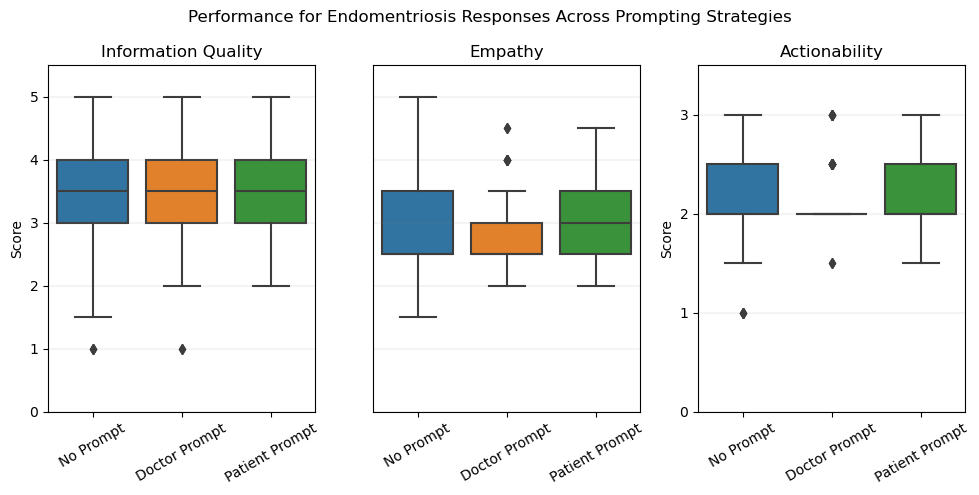

In [8]:
make_boxplots(grouped, fig_dir)

## Bootstrapping

In [9]:
def bootstrap(dataslice):

  # Bootstrap calculations
  trials = 1000
  bootstrapped_means = []
  k = len(dataslice)
  for i in range(trials):
    sample = dataslice.sample(n=k, replace=True)
    mean = sample.mean()
    bootstrapped_means.append(mean)

  sort = sorted(bootstrapped_means)
  low = sort[int(trials*0.025)]
  high = sort[int(trials*0.975)]

  return low, high

In [10]:
for metric in ["Information Quality","Empathy","Actionability"]:
   print(metric)
   for prompt in ['no_prompt', 'doc_prompt', 'pat_prompt']:

      x = grouped[(grouped['Medical Concern'] == 'Endometriosis')
         & (grouped['Prompt'] == prompt)
         & (grouped['Metric'] == metric) ]['Score']
      
      mean = x.mean()
      ci_low, ci_high = bootstrap(x)
      print(prompt, round(mean, 2), f'[{round(ci_low,2)}, {round(ci_high,2)}]')

Information Quality
no_prompt 3.34 [3.23, 3.44]
doc_prompt 3.4 [3.29, 3.52]
pat_prompt 3.38 [3.28, 3.48]
Empathy
no_prompt 2.8 [2.65, 2.96]
doc_prompt 2.75 [2.64, 2.87]
pat_prompt 3.04 [2.9, 3.2]
Actionability
no_prompt 2.12 [2.04, 2.21]
doc_prompt 2.14 [2.08, 2.2]
pat_prompt 2.16 [2.11, 2.22]


## Testing

In [18]:
for metric in ["Information Quality","Empathy","Actionability"]:
   print(metric)
   for prompt_pair in [('doc_prompt', 'no_prompt'), ('doc_prompt', 'pat_prompt'), ('pat_prompt', 'no_prompt')]:

      x = grouped[(grouped['Medical Concern'] == 'Endometriosis')
         & (grouped['Prompt'] == prompt_pair[0])
         & (grouped['Metric'] == metric) ]['Score'].values
      
      y = grouped[(grouped['Medical Concern'] == 'Endometriosis')
         & (grouped['Prompt'] == prompt_pair[1])
         & (grouped['Metric'] == metric) ]['Score'].values
   
      print(f'{prompt_pair[0]} and {prompt_pair[1]}')

      if stats.mannwhitneyu(x, y, alternative='two-sided')[1] < 0.05 and stats.wilcoxon(x, y, alternative='two-sided')[1] < 0.05:

         print(stats.mannwhitneyu(x, y, alternative='two-sided'))
         print(stats.wilcoxon(x, y, alternative='two-sided'),'\n')
      else:
         print('Not statistically significant\n')
   print('_______________')

Information Quality
doc_prompt and no_prompt
Not statistically significant

doc_prompt and pat_prompt
Not statistically significant

pat_prompt and no_prompt
Not statistically significant

_______________
Empathy
doc_prompt and no_prompt
Not statistically significant

doc_prompt and pat_prompt
MannwhitneyuResult(statistic=3631.0, pvalue=0.0038379904166268544)
WilcoxonResult(statistic=193.0, pvalue=3.122026109243214e-06) 

pat_prompt and no_prompt
MannwhitneyuResult(statistic=5660.0, pvalue=0.011415163324919573)
WilcoxonResult(statistic=506.0, pvalue=0.0019811602164813277) 

_______________
Actionability
doc_prompt and no_prompt
Not statistically significant

doc_prompt and pat_prompt
Not statistically significant

pat_prompt and no_prompt
Not statistically significant

_______________
